In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


In [3]:
%pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Load and preprocess the data
X = np.load(r"C:\Users\Irfan\partial_discharge\PD_detection\X.npy")
y = np.load(r"C:\Users\Irfan\partial_discharge\PD_detection\y.npy")

# Normalize the input features
X = X / np.max(X)

# Convert the labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_transformer_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Transformer Encoder
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x, x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = build_transformer_model(input_shape=X_train.shape[1:], num_classes=np.max(y_train) + 1)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 39)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 158, 128)     15104       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 158, 128)    512         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 158, 128)    131968      ['batch_normalization[0][0]',

MCC v/s Epoch and MCC v/s Loss

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 39)]    0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 158, 128)     15104       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 158, 128)    512         ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 158, 128)    131968      ['batch_normalization_2[0][

c:\Users\Irfan\anaconda3\lib\site-packages\keras\engine\training.py:2448: UserWarning: Metric MatthewsCorrelation implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


19/19 [==============================] - 13s 584ms/step - loss: 0.5963 - matthews_correlation: -0.0272 - val_loss: 0.4657 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
19/19 [==============================] - 12s 608ms/step - loss: 0.3102 - matthews_correlation: 0.0000e+00 - val_loss: 0.5390 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
19/19 [==============================] - 10s 535ms/step - loss: 0.2384 - matthews_correlation: 0.0000e+00 - val_loss: 0.4919 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
19/19 [==============================] - 10s 533ms/step - loss: 0.2125 - matthews_correlation: 0.0000e+00 - val_loss: 0.4811 - val_matthews_correlation: 0.0000e+00
Epoch 5/50
19/19 [==============================] - 10s 508ms/step - loss: 0.2058 - matthews_correlation: 0.0000e+00 - val_loss: 0.3791 - val_matthews_correlation: 0.0000e+00
Epoch 6/50
19/19 [==============================] - 10s 518ms/step - loss: 0.1988 - matthews_correlation: 1.4684e-06 - val_loss: 0.2645 - v

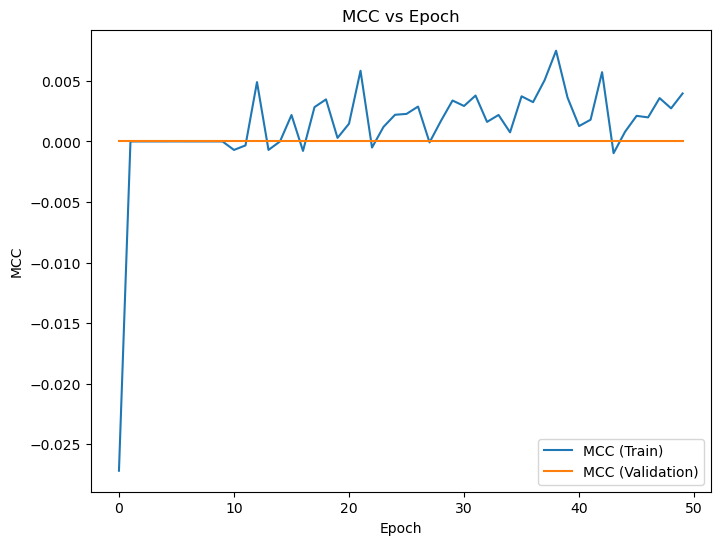

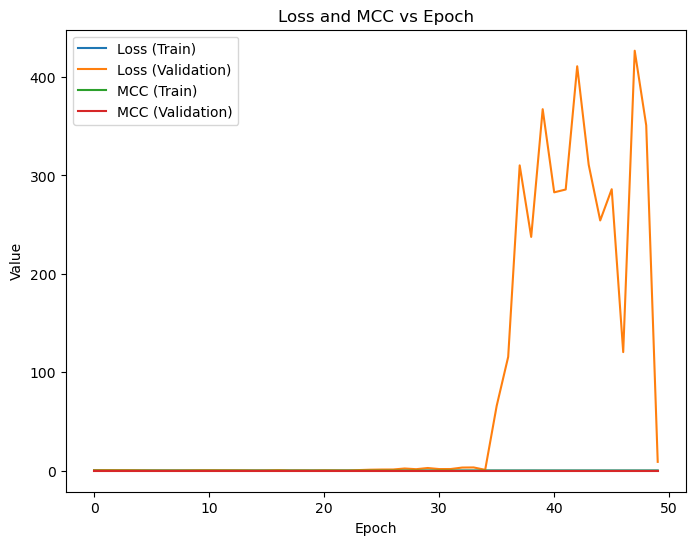

In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the Matthews Correlation Coefficient (MCC) metric
class MatthewsCorrelation(tf.keras.metrics.Metric):
    def __init__(self, name='matthews_correlation', **kwargs):
        super(MatthewsCorrelation, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(y_true, tf.int64)

        true_pos = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
        true_neg = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0)), tf.float32))
        false_pos = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), tf.float32))
        false_neg = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), tf.float32))

        self.true_positives.assign_add(true_pos)
        self.true_negatives.assign_add(true_neg)
        self.false_positives.assign_add(false_pos)
        self.false_negatives.assign_add(false_neg)

    def result(self):
        numerator = self.true_positives * self.true_negatives - self.false_positives * self.false_negatives
        denominator = tf.math.sqrt((self.true_positives + self.false_positives) * (self.true_positives + self.false_negatives) *
                                   (self.true_negatives + self.false_positives) * (self.true_negatives + self.false_negatives) + 1e-15)
        mcc = numerator / denominator
        return mcc

    def reset_states(self):
        self.true_positives.assign(0.)
        self.true_negatives.assign(0.)
        self.false_positives.assign(0.)
        self.false_negatives.assign(0.)

# Build and compile the model with MCC as a metric
model = build_transformer_model(input_shape=X_train.shape[1:], num_classes=np.max(y_train) + 1)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=[MatthewsCorrelation()])
model.summary()
# Training
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(X_test, y_test)
)

# Extract metrics and loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mcc = history.history['matthews_correlation']
val_mcc = history.history['val_matthews_correlation']

# Plot MCC vs epoch
plt.figure(figsize=(8, 6))
plt.plot(train_mcc, label='MCC (Train)')
plt.plot(val_mcc, label='MCC (Validation)')
plt.xlabel('Epoch')
plt.ylabel('MCC')
plt.title('MCC vs Epoch')
plt.legend()
plt.show()

# Plot loss vs MCC
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Loss (Train)')
plt.plot(val_loss, label='Loss (Validation)')
plt.plot(train_mcc, label='MCC (Train)')
plt.plot(val_mcc, label='MCC (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and MCC vs Epoch')
plt.legend()
plt.show()


